In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.losses import MeanSquaredError,CategoricalCrossentropy
mse = MeanSquaredError()
cce = CategoricalCrossentropy()

# shunqing

## Prediction

In [2]:
cwd = './results/shunqing/5s_20k_edge_res_norm_flood/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [3]:
from utilities import get_inp_files
from envs import get_env
env = get_env('shunqing')()
train_id = np.load('./model/shunqing/5s_20k_edge_res_norm_flood/train_id.npy')
events = get_inp_files(env.config['swmm_input'],env.config['rainfall'])
[event for idx,event in enumerate(events) if idx not in train_id]

c:\Users\chong\anaconda3\envs\storm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['./envs/network/shunqing/bpswmm_64.inp',
 './envs/network/shunqing/bpswmm_67.inp',
 './envs/network/shunqing/bpswmm_610.inp',
 './envs/network/shunqing/bpswmm_616.inp',
 './envs/network/shunqing/bpswmm_618.inp',
 './envs/network/shunqing/bpswmm_76.inp',
 './envs/network/shunqing/bpswmm_715.inp',
 './envs/network/shunqing/bpswmm_720.inp',
 './envs/network/shunqing/bpswmm_721.inp',
 './envs/network/shunqing/bpswmm_84.inp',
 './envs/network/shunqing/bpswmm_810.inp',
 './envs/network/shunqing/bpswmm_814.inp',
 './envs/network/shunqing/bpswmm_819.inp',
 './envs/network/shunqing/bpswmm_820.inp',
 './envs/network/shunqing/bpswmm_912.inp',
 './envs/network/shunqing/bpswmm_915.inp',
 './envs/network/shunqing/bpswmm_102.inp',
 './envs/network/shunqing/bpswmm_1010.inp',
 './envs/network/shunqing/bpswmm_1012.inp',
 './envs/network/shunqing/bpswmm_1017.inp',
 './envs/network/shunqing/bpswmm_114.inp',
 './envs/network/shunqing/bpswmm_133.inp',
 './envs/network/shunqing/bpswmm_162.inp',
 './envs/net

### Nodes

In [4]:
event = 'bpswmm_61'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred


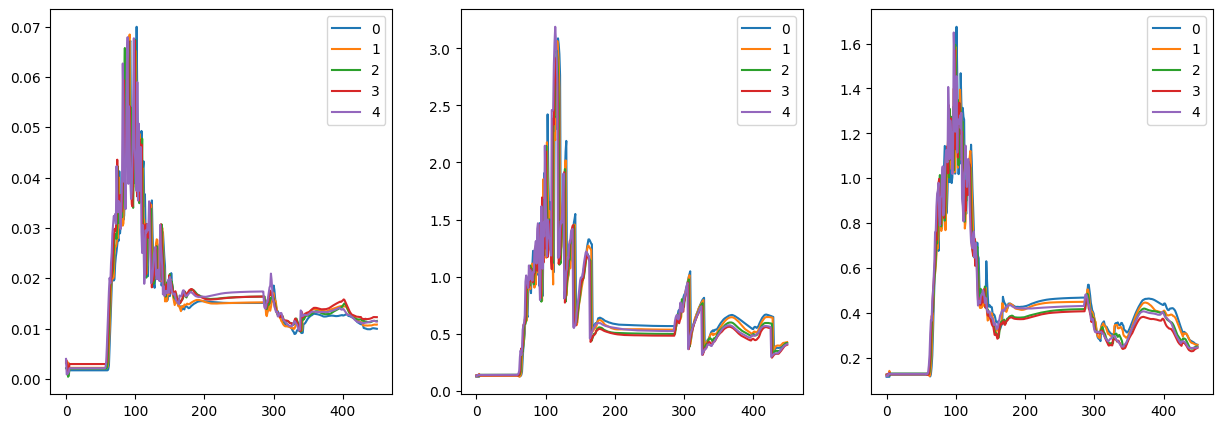

In [5]:
# true = np.load(os.path.join(cwd,event+'_true.npy'))
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

Text(0.5, 1.0, 'Flooding')

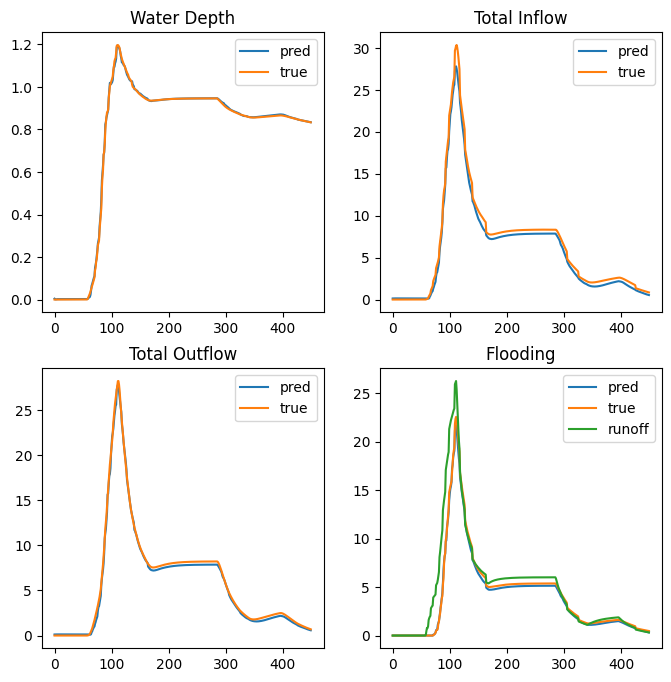

In [6]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1

ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,...].mean(axis=1)[:,-1],label='pred')
ax4.plot(true[:,seq,...].mean(axis=1)[:,-1],label='true')
ax4.plot(r[:,seq,...].mean(axis=1),label='runoff')
ax4.legend()
ax4.set_title('Flooding')

- Select a Node to plot, what is the outlet boundary?
- Cannot predict water level of a specific node precisely
    - Possibly because it depends on both up and downstream
    - Or it can be better if nodes have storage volumes: not significant
    - Water level error makes up with small loss: Normalization works
- Cannot Predict flooding precisely
    - Classify flooding or not: It works!!!

In [37]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
nodes = [k for k in inp.JUNCTIONS]

Text(0.5, 1.0, 'Flooding')

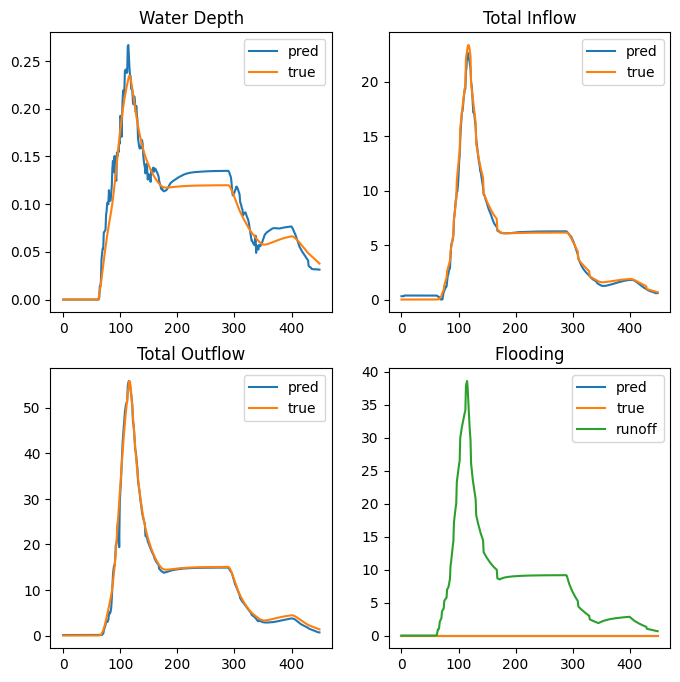

In [40]:
idx = nodes.index('jd27')
seq = 0

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,idx,-1],label='pred')
ax4.plot(true[:,seq,idx,-1],label='true')
ax4.plot(r[:,seq,idx,0],label='runoff')
ax4.legend()
ax4.set_title('Flooding')

### Edges

In [41]:
event = 'bpswmm_61'
true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
err = true - pred
err.shape

(450, 5, 131, 3)

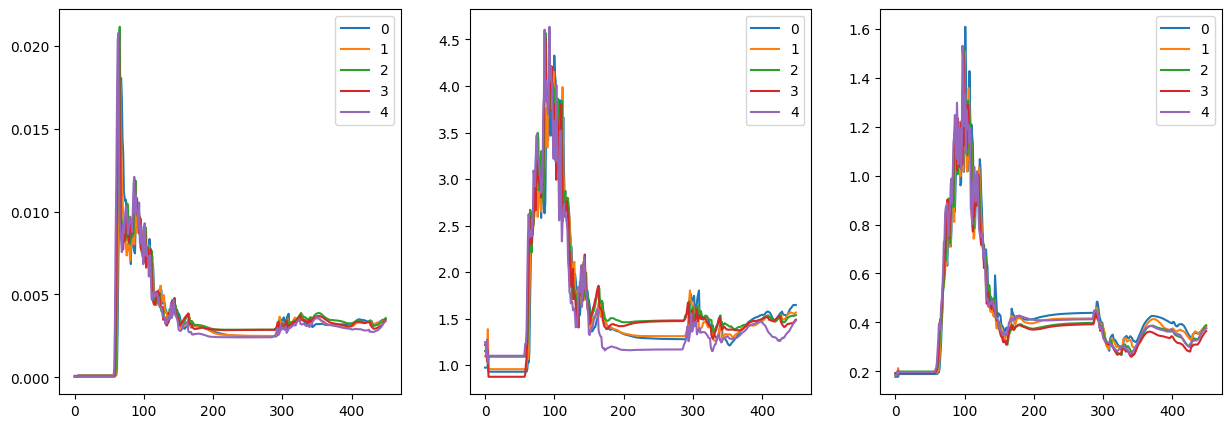

In [42]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

Text(0.5, 1.0, 'Link flow')

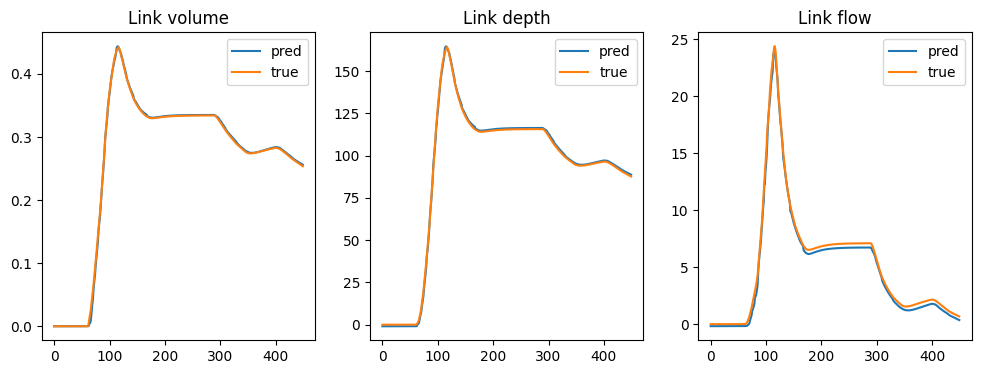

In [43]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
seq = 0

ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Link volume')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Link depth')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Link flow')


In [44]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
links = [k for k in list(inp.CONDUITS)]


In [323]:
import pandas as pd
rmse = pd.DataFrame(columns=['volume','depth','flow'])
for j in range(err.shape[1]):
    rmse.loc[j] = np.sqrt(((pred[:,j,idx,:] - true[:,j,idx,:])**2).mean(axis=0))
rmse

,volume,depth,flow
0,0.036325,43.591695,2.934570
1,0.037282,43.711721,2.907389
2,0.034496,40.853893,2.714485
3,0.034116,41.004194,2.761448
4,0.035840,43.635173,3.248093


Text(0.5, 1.0, 'Link flow')

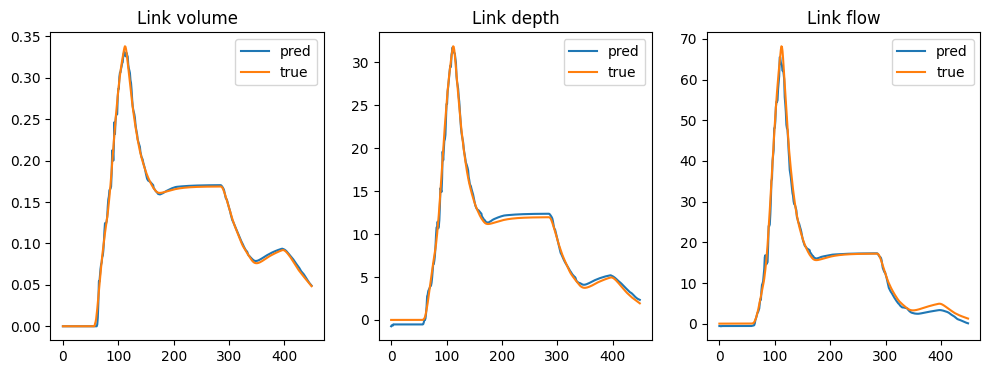

In [45]:
seq = -1
idx = links.index('GQ76')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Link volume')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Link depth')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Link flow')


### Debug inflow & outflow

In [23]:
import numpy as np
event_id = np.load('./envs/data/shunqing/edge/event_id.npy')
edge_states = np.load('./envs/data/shunqing/edge/edge_states.npy')[event_id==0]
states = np.load('./envs/data/shunqing/edge/states.npy')[event_id==0]


In [4]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
nodes = [k for k in list(inp.JUNCTIONS)+list(inp.OUTFALLS)]
idx = nodes.index('jd30')
edges = [k for k in list(inp.CONDUITS)]
idxe = [edges.index(e) for e in ['GQ16','GQ38','GQ75','GQ73']]

In [5]:
import pandas as pd
jd = pd.DataFrame()
jd['tot_in'],jd['tot_out'],jd['lat_in'] = states[:,idx,1],states[:,idx,2],states[:,idx,3]
links = ['GQ16','GQ38','GQ75','GQ73']
jd[links] = np.array([edge_states[:,e,-1] for e in idxe]).T
jd

,tot_in,tot_out,lat_in,GQ16,GQ38,GQ75,GQ73
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
396,4.263206,4.008364,1.610603,2.526705,-0.403256,0.661647,2.943461
397,4.275959,4.026690,1.614094,2.538565,-0.404979,0.664665,2.957045
398,4.288628,4.044597,1.617667,2.550150,-0.406663,0.667615,2.970319
399,4.301039,4.062131,1.621246,2.561484,-0.408312,0.670503,2.983316


In [18]:
jd['GQ73']+jd['GQ75'] - jd['tot_out']

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
396   -0.403256
397   -0.404979
398   -0.406663
399   -0.408312
400   -0.409168
Length: 401, dtype: float64

### Inverse conduits

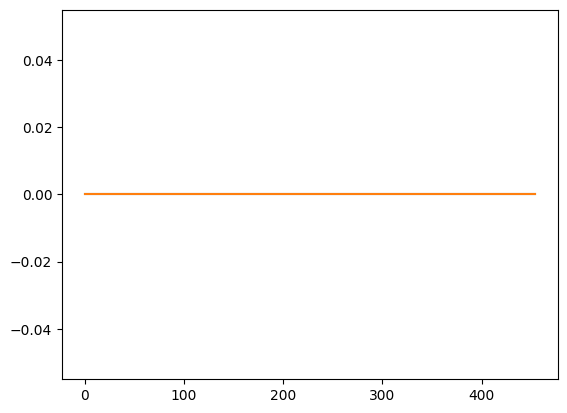

In [27]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
edges = np.array([k for k in list(inp.CONDUITS)])
import numpy as np
event_id = np.load('./envs/data/shunqing/edge/event_id.npy')
edge_states = np.load('./envs/data/shunqing/edge/edge_states.npy')[event_id==0]
flow = edge_states[...,-2]
inv_edges_idx = (1-np.sum(flow>0,axis=0)>0).nonzero()
for idx in inv_edges_idx:
    plt.plot(flow[:,idx])

In [28]:
edges[inv_edges_idx]

array(['GQ77', 'GQ120'], dtype='<U5')

In [148]:
(1-np.sum(flow>0,axis=0)>0).nonzero()[0]

array([  1,   4,   5,   8,  11,  16,  19,  21,  22,  23,  26,  27,  32,
        36,  37,  40,  46,  47,  48,  49,  52,  54,  57,  60,  61,  64,
        68,  76,  77,  79,  84,  85,  86,  87,  94,  97, 102, 103, 105,
       106, 107, 109, 115, 119, 121, 123, 129, 130], dtype=int64)

In [147]:
(np.sum(flow<0,axis=0)>0).nonzero()[0]

array([  1,   4,   5,   8,  11,  16,  17,  19,  21,  22,  23,  26,  27,
        28,  32,  36,  37,  40,  46,  47,  48,  49,  52,  54,  57,  59,
        60,  61,  64,  66,  68,  77,  78,  79,  84,  85,  86,  87,  94,
        97, 102, 103, 104, 105, 106, 107, 109, 113, 115, 120, 121, 123,
       129, 130], dtype=int64)

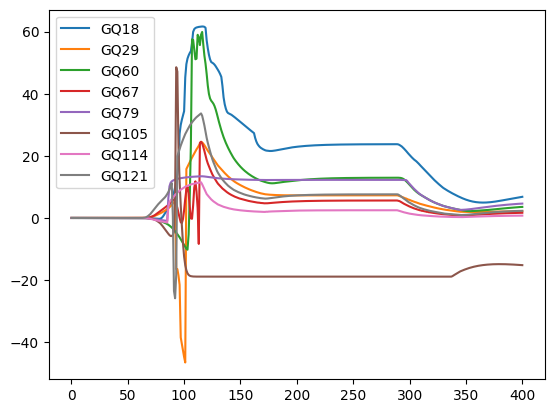

In [153]:
idxs = [idx for idx in (np.sum(flow<0,axis=0)>0).nonzero()[0] if idx not in (1-np.sum(flow>0,axis=0)>0).nonzero()[0]]
for idx in idxs:
    plt.plot(flow[:,idx],label = edges[idx])
plt.legend()

In [157]:
for edge in edges[inv_edges_idx].tolist()+['GQ105']:
    cond = inp['CONDUITS'][edge]
    cond.FromNode,cond.ToNode = cond.ToNode,cond.FromNode
    cond.InOffset,cond.OutOffset = cond.OutOffset,cond.InOffset

In [159]:
inp.write_file('./envs/network/shunqing/shunqing.inp')

'./envs/network/shunqing/shunqing.inp'

### Debug inflow & flow

In [245]:
from envs import get_env
env = get_env('shunqing')()
node_edge = env.get_args()['node_edge']

In [305]:
edge_true = np.load('./results/shunqing/5s_edge_res_norm_flood/bpswmm_2412_edge_true.npy')
true = np.load('./results/shunqing/5s_edge_res_norm_flood/bpswmm_2412_true.npy')
node_outflow = np.matmul(np.clip(node_edge,0,1),np.clip(edge_true[...,-1:],0,np.inf)) + np.matmul(np.abs(np.clip(node_edge,-1,0)),-np.clip(edge_true[...,-1:],-np.inf,0))
node_inflow = np.matmul(np.abs(np.clip(node_edge,-1,0)),np.clip(edge_true[...,-1:],0,np.inf)) + np.matmul(np.clip(node_edge,0,1),-np.clip(edge_true[...,-1:],-np.inf,0))

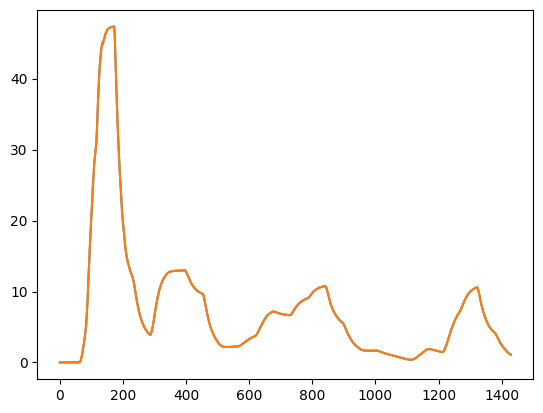

In [306]:
plt.plot(node_outflow[:,0,:,0].mean(axis=1))
plt.plot(true[:,0,:,2].mean(axis=1))

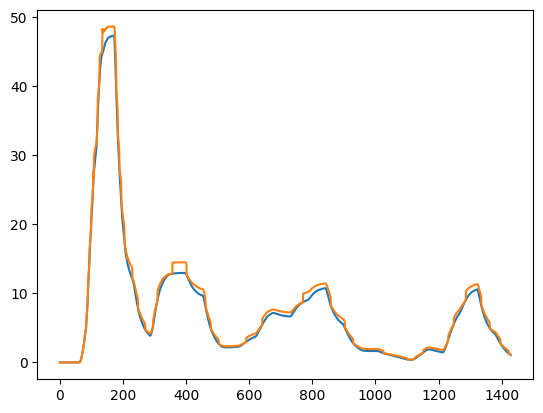

In [307]:
plt.plot(node_inflow[:,0,:,0].mean(axis=1))
plt.plot(true[:,0,:,1].mean(axis=1))

In [327]:
edge_pred = np.load('./results/shunqing/5s_edge_res_norm_flood/bpswmm_2412_edge_pred.npy')
pred = np.load('./results/shunqing/5s_edge_res_norm_flood/bpswmm_2412_pred.npy')
node_outflow = np.matmul(np.clip(node_edge,0,1),np.clip(edge_pred[...,-1:],0,np.inf))
node_inflow = np.matmul(np.abs(np.clip(node_edge,-1,0)),np.clip(edge_pred[...,-1:],0,np.inf))

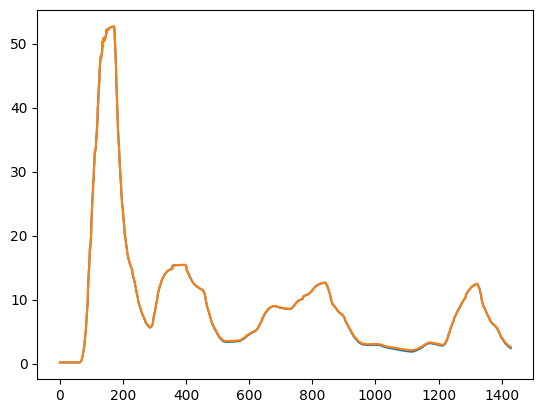

In [328]:
plt.plot(node_outflow[:,0,:,0].mean(axis=1))
plt.plot(pred[:,0,:,2].mean(axis=1))

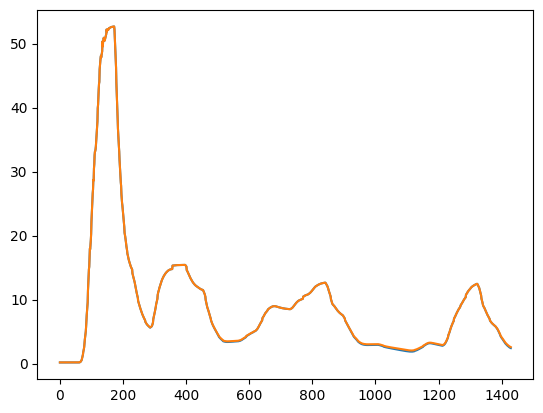

In [329]:
plt.plot(node_inflow[:,0,:,0].mean(axis=1))
plt.plot(pred[:,0,:,1].mean(axis=1))

## Train loss

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [30]:
cwd = './model/shunqing/5s_20k_edge_res_norm_flood/'
train_losses = np.load(os.path.join(cwd,'train_loss.npy'))
test_losses = np.load(os.path.join(cwd,'test_loss.npy'))
train_ids = np.load(os.path.join(cwd,'train_id.npy'))
test_ids = np.load(os.path.join(cwd,'test_id.npy'))

In [5]:
train_ids

array([108,  55,   3,  43, 146,  19, 125,   3, 135,  58,   1,  71,  26,
        78, 130,  76,  54, 111, 123, 121,  99, 135, 141, 130,   5, 124,
         6,  25,  50, 127,   6,   2, 104,  77,  86, 141, 116,  18,  13,
        76,  91,  12, 123, 130,  19,  64,  72,  96,  77,  67,   3,  68,
        29,   7, 122,  76, 127,  14,  11,  55,  46,  91,  20, 124,  89,
        31,   7,  23,  80,   6,  46,  20,  69, 137,  77, 100,   5,  37,
         7,  22,  96,  79, 108,  90,  97,  38, 130, 133,  33, 118,  88,
       101,  79,  48, 142, 122,  84,  38,  98,  66, 132,  74,  18,  87,
        33,  38,  33,  26,   0,  41,  95,  68,  69,  58, 119,  53,  81,
       121])

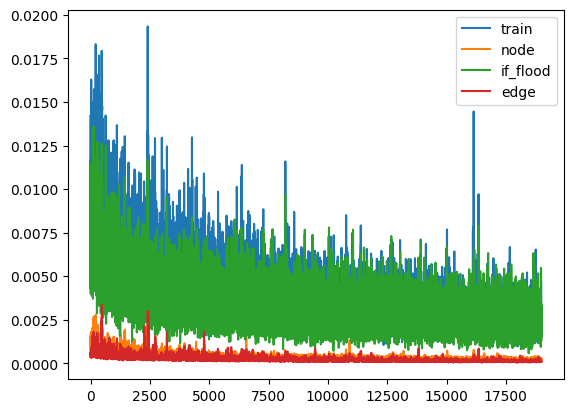

In [31]:
plt.plot(train_losses[1000:],label='train')
plt.plot(test_losses[1000:],label=['node','if_flood','edge'])
# plt.plot([sum(los) for los in test_losses[1000:]],label='test')
plt.legend()

# RedChicoSur

## Prediction

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
cwd = './results/RedChicoSur/5s_20k_edge_res_norm_flood/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [3]:
from utilities import get_inp_files
from envs import get_env
env = get_env('RedChicoSur')()
train_id = np.load('./model/RedChicoSur/5s_20k_edge_res_norm_flood/train_id.npy')
events = get_inp_files(env.config['swmm_input'],env.config['rainfall'])
[event for idx,event in enumerate(events) if idx not in train_id]

c:\Users\chong\anaconda3\envs\storm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['./envs/network/RedChicoSur/08_08_14.inp',
 './envs/network/RedChicoSur/eval_0.inp',
 './envs/network/RedChicoSur/train_0.inp',
 './envs/network/RedChicoSur/train_11.inp',
 './envs/network/RedChicoSur/train_17.inp',
 './envs/network/RedChicoSur/train_9.inp']

### Nodes

In [4]:
event = 'train_0'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred
err.shape

(342, 5, 443, 6)

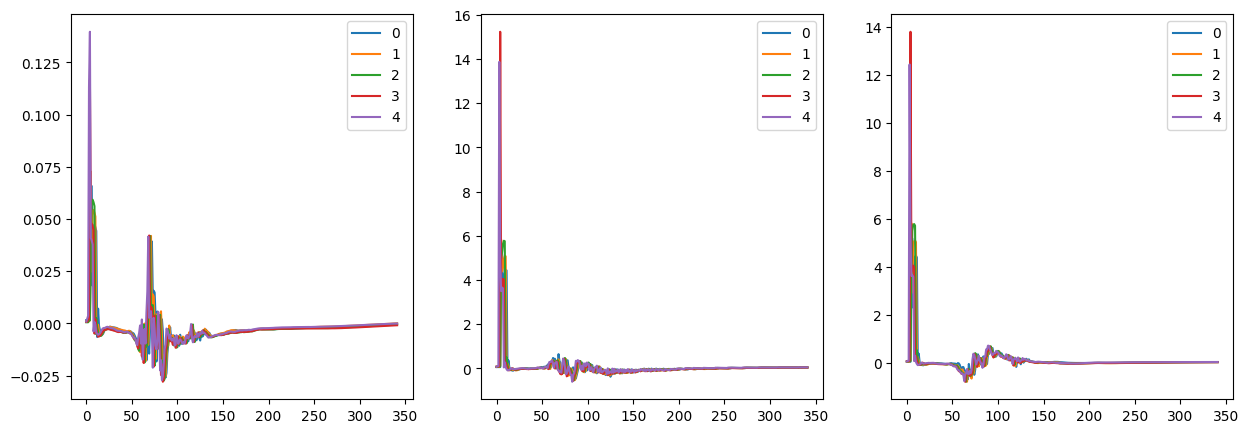

In [5]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(5):
        ax.plot(pred.mean(axis=2)[:,j,i]-true.mean(axis=2)[:,j,i],label=j)
    ax.legend()

In [6]:
import pandas as pd
rmse = pd.DataFrame(columns=['depth','inflow','outflow','flood'])
for j in range(err.shape[1]):
    rmse.loc[j] = np.sqrt(((np.concatenate([pred[:,j,...,:3],pred[:,j,...,-1:]],axis=-1).mean(axis=1) - np.concatenate([true[:,j,...,:3],true[:,j,...,-1:]],axis=-1).mean(axis=1))**2).mean(axis=0))
rmse

,depth,inflow,outflow,flood
0,0.009124,0.653847,0.646752,0.066662
1,0.008993,0.672046,0.665267,0.066700
2,0.008886,0.675077,0.666739,0.066721
3,0.010103,0.931400,0.875204,0.489757
4,0.011826,0.872013,0.822300,0.451795


Text(0.5, 1.0, 'Flooding')

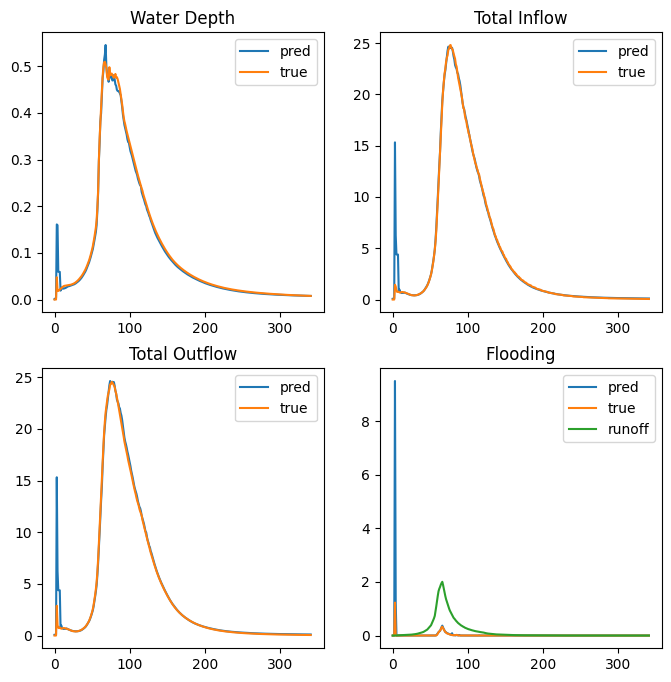

In [12]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1


ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,...].mean(axis=1)[:,-1],label='pred')
ax4.plot(true[:,seq,...].mean(axis=1)[:,-1],label='true')
ax4.plot(r[:,seq,...].mean(axis=1),label='runoff')
ax4.legend()
ax4.set_title('Flooding')

In [8]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/RedChicoSur/RedChicoSur.inp')
nodes = [k for k in list(inp.JUNCTIONS)+list(inp.OUTFALLS)]
idx = nodes.index('DESC')

In [9]:
import pandas as pd
rmse = pd.DataFrame(columns=['depth','inflow','outflow','flood'])
for j in range(err.shape[1]):
    rmse.loc[j] = np.sqrt(((np.concatenate([pred[:,j,idx,:3],pred[:,j,idx,-1:]],axis=-1) - np.concatenate([true[:,j,idx,:3],true[:,j,idx,-1:]],axis=-1))**2).mean(axis=0))
rmse

,depth,inflow,outflow,flood
0,0.019829,4.114391,0.0,0.0
1,0.018674,4.008110,0.0,0.0
2,0.018593,4.107725,0.0,0.0
3,0.019285,3.906036,0.0,0.0
4,0.019066,3.952546,0.0,0.0


Text(0.5, 1.0, 'Flooding')

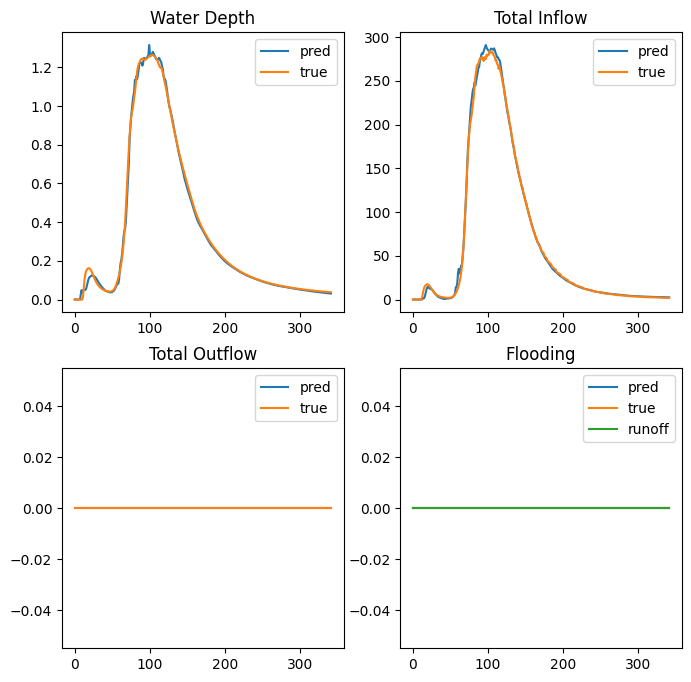

In [11]:
seq = -1

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,idx,-1],label='pred')
ax4.plot(true[:,seq,idx,-1],label='true')
ax4.plot(r[:,seq,idx,0],label='runoff')
ax4.legend()
ax4.set_title('Flooding')

### Edge

In [13]:
event = 'train_0'
true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
err = true - pred
err.shape

(342, 5, 444, 3)

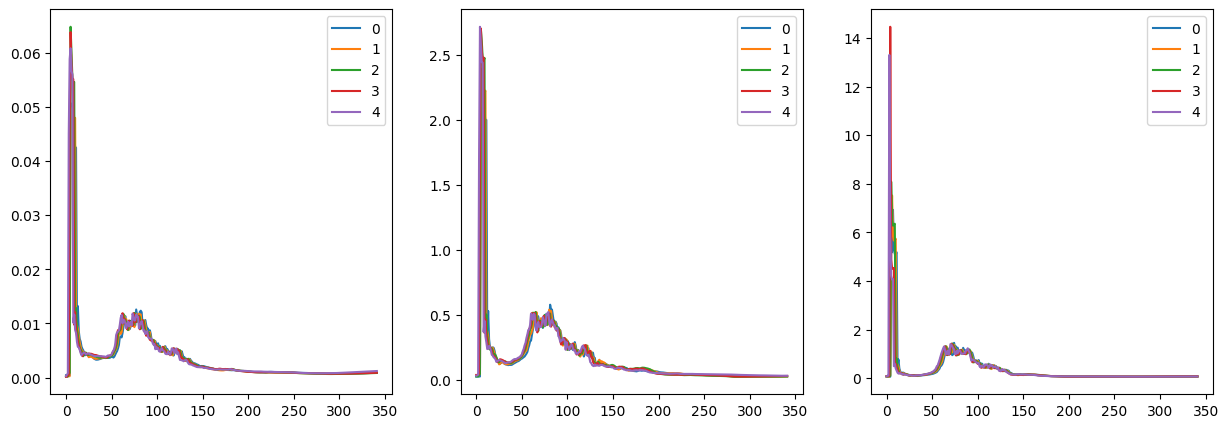

In [14]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

In [15]:
import pandas as pd
rmse = pd.DataFrame(columns=['volume','depth','flow'])
for j in range(err.shape[1]):
    rmse.loc[j] = np.sqrt(((pred[:,j,...].mean(axis=1) - true[:,j,...].mean(axis=1))**2).mean(axis=0))
rmse

,volume,depth,flow
0,0.005540,0.222181,0.299568
1,0.005821,0.236092,0.333667
2,0.005906,0.239622,0.374125
3,0.005757,0.217993,0.433848
4,0.005847,0.222667,0.408137


Text(0.5, 1.0, 'Link flow')

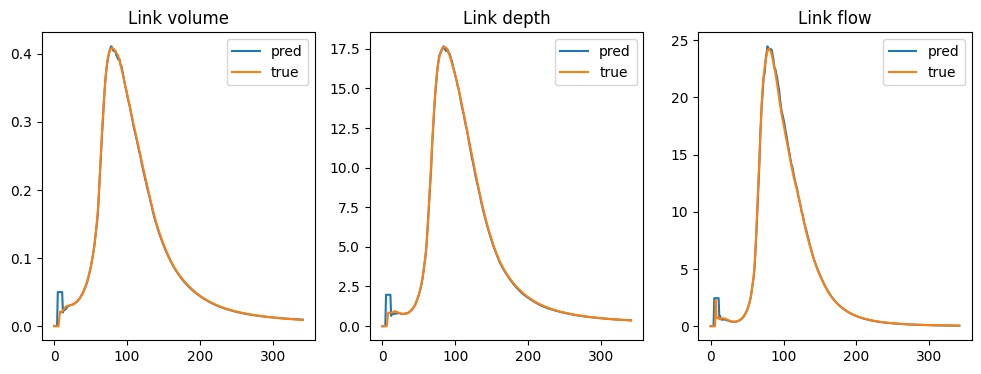

In [16]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
seq = 0

ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Link volume')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Link depth')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Link flow')


In [17]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/RedChicoSur/RedChicoSur.inp')
links = [k for k in list(inp.CONDUITS)+list(inp.ORIFICES)]
idx = links.index('PLT85829')


In [18]:
import pandas as pd
rmse = pd.DataFrame(columns=['volume','depth','flow'])
for j in range(err.shape[1]):
    rmse.loc[j] = np.sqrt(((pred[:,j,idx,:] - true[:,j,idx,:])**2).mean(axis=0))
rmse

,volume,depth,flow
0,0.001604,0.021338,0.098346
1,0.001627,0.021850,0.102317
2,0.001594,0.020188,0.094380
3,0.001699,0.021436,0.094697
4,0.001695,0.020029,0.090978


Text(0.5, 1.0, 'Link flow')

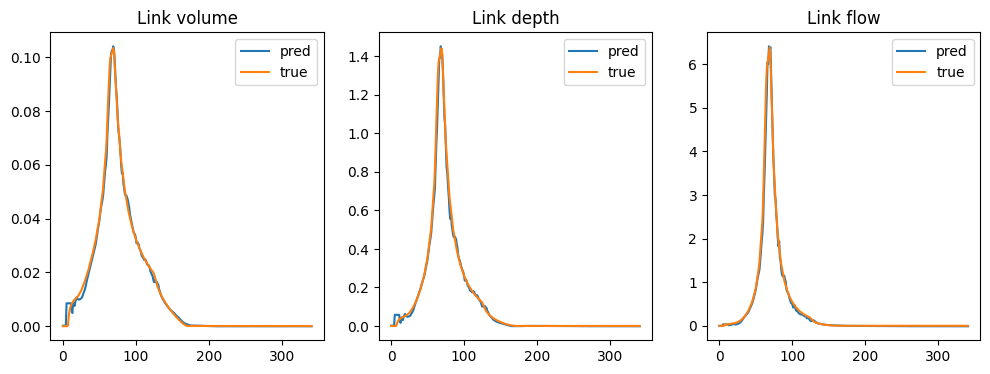

In [19]:
seq = 0

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Link volume')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Link depth')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Link flow')



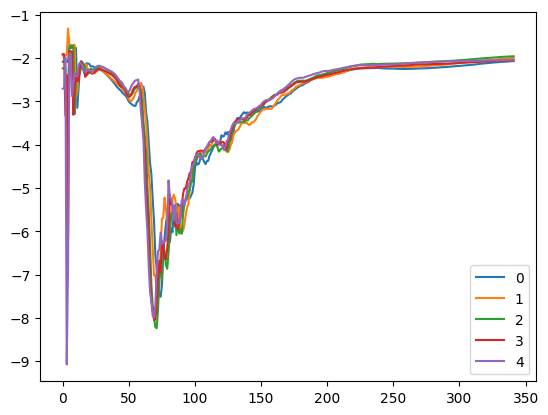

In [94]:
# debug node-edge balance loss
from envs import get_env
from numpy import matmul
event='train_0'
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))

env = get_env('RedChicoSur')()
env_args = env.get_args()
err = matmul(np.abs(env_args['node_edge']),edge_pred[...,-1:]) - pred[...,1:2] - pred[...,2:3]
for j in range(err.shape[1]):
    plt.plot(err.mean(axis=2)[:,j],label=j)
plt.legend()

## Training

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
cwd = './model/RedChicoSur/5s_20k_edge_res_norm_flood/'
train_losses = np.load(os.path.join(cwd,'train_loss.npy'))
test_losses = np.load(os.path.join(cwd,'test_loss.npy'))
train_ids = np.load(os.path.join(cwd,'train_id.npy'))
test_ids = np.load(os.path.join(cwd,'test_id.npy'))

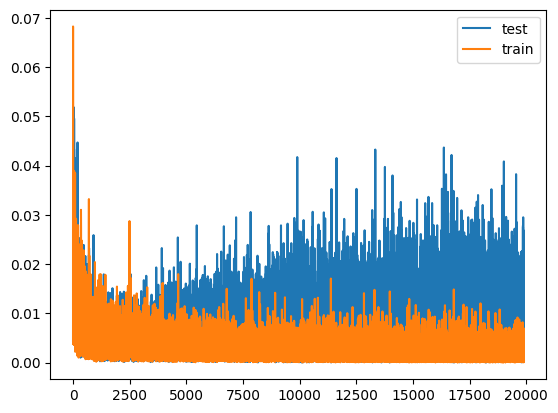

In [9]:
plt.plot(test_losses[100:].sum(axis=1),label='test')
plt.plot(train_losses[100:],label='train')
plt.legend()

# astlingen

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
cwd = './results/astlingen/10s_20k_efd_edge_res_norm_flood/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))
event = 'astlingen_01_08_2002_19'

### Node

In [3]:
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred

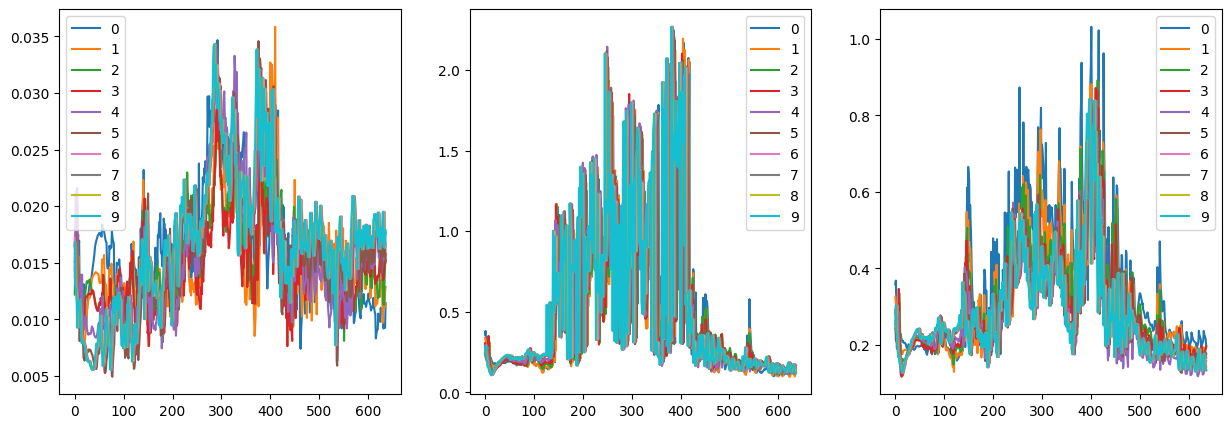

In [4]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

Text(0.5, 1.0, 'Flooding')

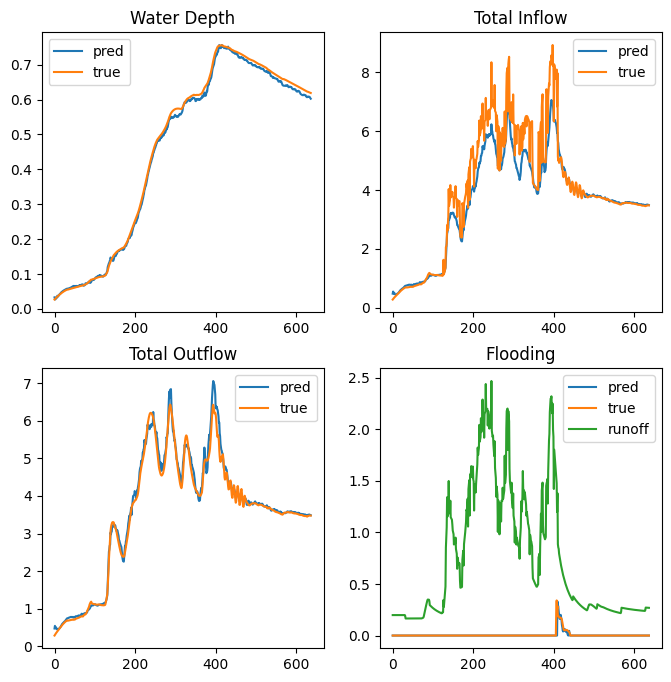

In [5]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1

ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,...].mean(axis=1)[:,-1],label='pred')
ax4.plot(true[:,seq,...].mean(axis=1)[:,-1],label='true')
ax4.plot(r[:,seq,...].mean(axis=1),label='runoff')
ax4.legend()
ax4.set_title('Flooding')

### Edge

In [6]:
edge_true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
err = edge_true - edge_pred
err.shape

(637, 10, 29, 3)

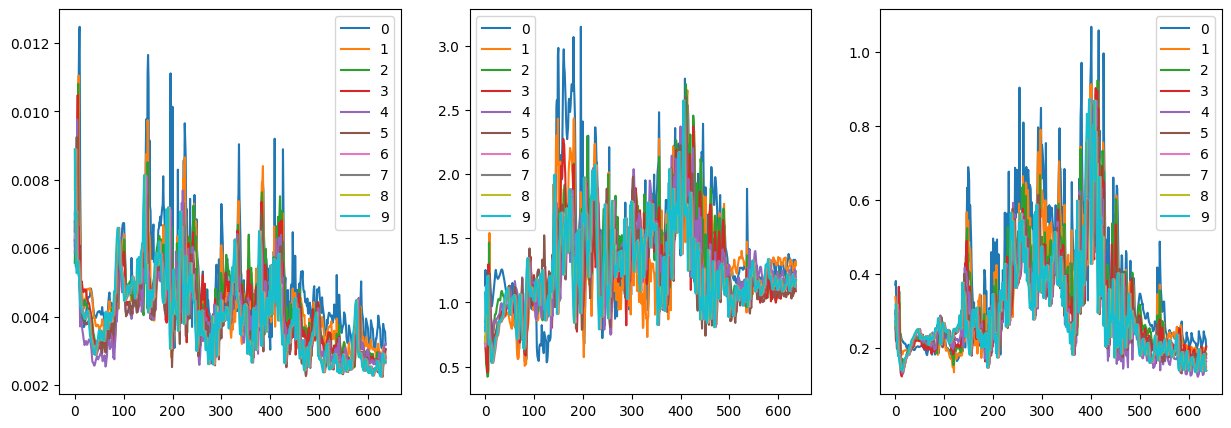

In [7]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

Text(0.5, 1.0, 'Link flow')

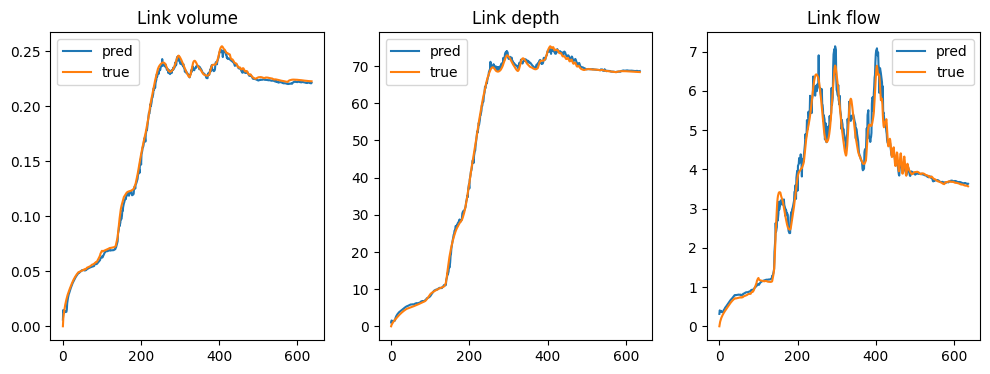

In [8]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
seq = 0

ax1.plot(edge_pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(edge_true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Link volume')

ax2.plot(edge_pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(edge_true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Link depth')

ax3.plot(edge_pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(edge_true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Link flow')


### Element-level

In [9]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/astlingen/astlingen.inp')
nodes = [k for k in list(inp.OUTFALLS)+list(inp.JUNCTIONS)+list(inp.STORAGE)]
links = [k for k in list(inp.CONDUITS)+list(inp.ORIFICES)]

/home/zhiyu/miniconda3/envs/storm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0.5, 1.0, 'Flooding')

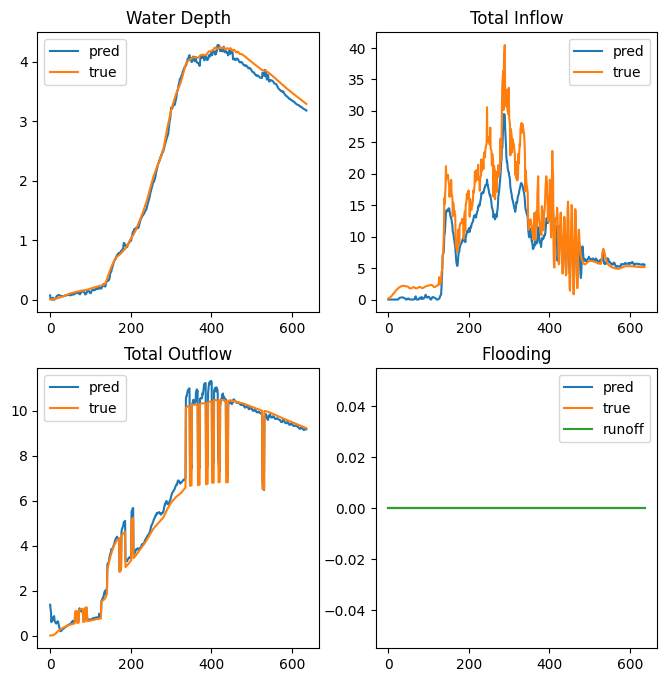

In [10]:
idx = nodes.index('T3')
seq = -1

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,idx,-1],label='pred')
ax4.plot(true[:,seq,idx,-1],label='true')
ax4.plot(r[:,seq,idx,0],label='runoff')
ax4.legend()
ax4.set_title('Flooding')

Text(0.5, 1.0, 'Link flow')

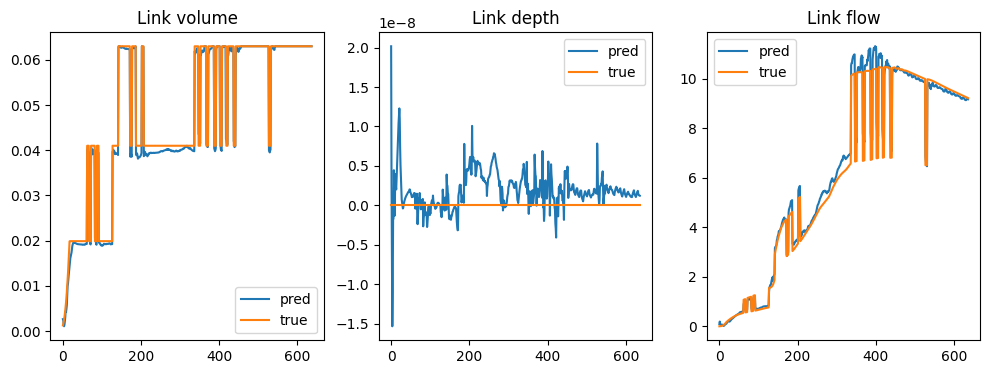

In [11]:
seq = -1
idx = links.index('V3')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

ax1.plot(edge_pred[:,seq,idx,0],label='pred')
ax1.plot(edge_true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Link volume')

ax2.plot(edge_pred[:,seq,idx,1],label='pred')
ax2.plot(edge_true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Link depth')

ax3.plot(edge_pred[:,seq,idx,2],label='pred')
ax3.plot(edge_true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Link flow')


### Train loss

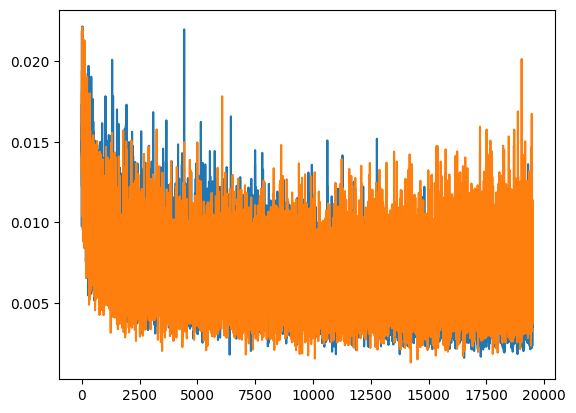

In [4]:
train_losses = np.load('./model/astlingen/10s_20k_act_edge_res_norm_flood/train_loss.npy')
test_losses = np.load('./model/astlingen/10s_20k_act_edge_res_norm_flood/test_loss.npy')
plt.plot(train_losses[500:20000])
plt.plot([sum(los) for los in test_losses[500:20000]])

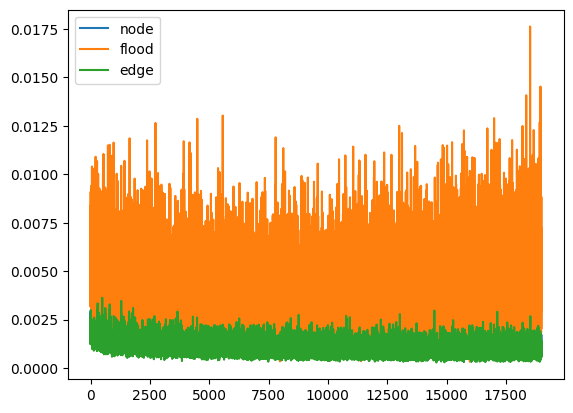

In [5]:
plt.plot(test_losses[1000:],label=['node','flood','edge'])
plt.legend()

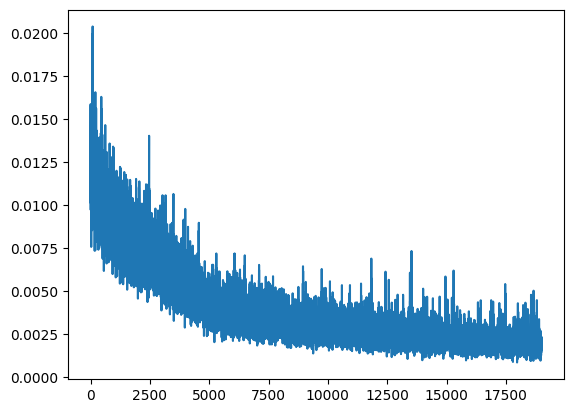

In [138]:
train_losses = np.load('./model/astlingen/10s_20k_res_norm_flood/train_loss.npy')
test_losses = np.load('./model/astlingen/10s_20k_res_norm_flood/test_loss.npy')
plt.plot(train_losses[1000:20000])
plt.plot([sum(los) for los in test_losses[1000:20000]])

### Debug

In [110]:
from envs import get_env
env = get_env('astlingen')()
env_args = env.get_args()
node_edge = env_args['node_edge']

In [120]:
edge_true = np.load('./results/astlingen/5s_edge_res_norm_flood/astlingen_02_08_2002_21_edge_true.npy')
true = np.load('./results/astlingen/5s_edge_res_norm_flood/astlingen_02_08_2002_21_true.npy')
node_outflow = np.matmul(np.clip(node_edge,0,1),np.clip(edge_true[...,-1:],0,np.inf)) + np.matmul(np.abs(np.clip(node_edge,-1,0)),-np.clip(edge_true[...,-1:],-np.inf,0))
node_inflow = np.matmul(np.abs(np.clip(node_edge,-1,0)),np.clip(edge_true[...,-1:],0,np.inf)) + np.matmul(np.clip(node_edge,0,1),-np.clip(edge_true[...,-1:],-np.inf,0))

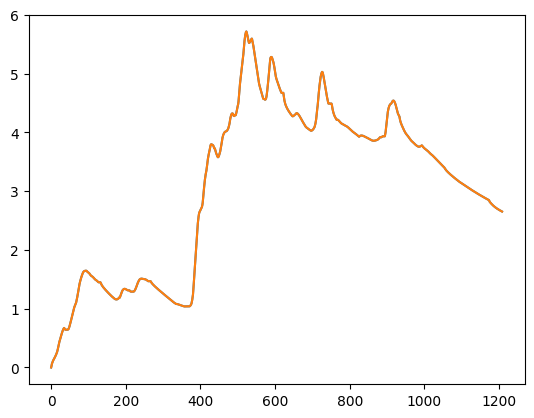

In [121]:
plt.plot(node_outflow[:,0,:,0].mean(axis=1))
plt.plot(true[:,0,:,2].mean(axis=1))

In [115]:
edge_pred = np.load('./results/astlingen/5s_edge_res_norm_flood/astlingen_02_08_2002_21_edge_pred.npy')
pred = np.load('./results/astlingen/5s_edge_res_norm_flood/astlingen_02_08_2002_21_pred.npy')
node_outflow = np.matmul(np.clip(node_edge,0,1),np.clip(edge_pred[...,-1:],0,np.inf)) + np.matmul(np.abs(np.clip(node_edge,-1,0)),-np.clip(edge_pred[...,-1:],-np.inf,0))
node_inflow = np.matmul(np.abs(np.clip(node_edge,-1,0)),np.clip(edge_pred[...,-1:],0,np.inf)) + np.matmul(np.clip(node_edge,0,1),-np.clip(edge_pred[...,-1:],-np.inf,0))

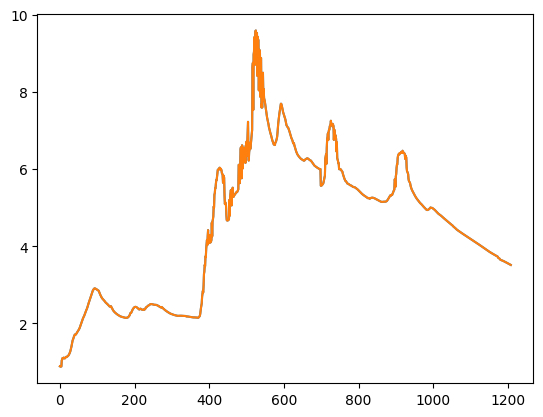

In [116]:
plt.plot(node_outflow[:,0,:,0].mean(axis=1))
plt.plot(pred[:,0,:,2].mean(axis=1))

In [134]:
env.get_features('links')

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C2',
 'C20',
 'C21',
 'C22',
 'C23',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6']

### Rainfalls

In [127]:
import pandas as pd
rain = pd.read_csv('./envs/config/ast_rain_events.csv',index_col=0)
rain = rain[rain['Precipitation'].apply(lambda x:5<x<15)]
train = rain[rain['Date'].apply(lambda x:eval(x[-1])<7)]
test = rain[rain['Date'].apply(lambda x:eval(x[-1])>6)]
train.to_csv('./envs/config/ast_train_events.csv')
test.to_csv('./envs/config/ast_test_events.csv')